# **Week2 복습과제**

**1. [ANN]**

**2. [CNN]**

- 데이터는 Week 1 과 같이 MNIST (0-9 숫자 분류) 데이터셋입니다.
- 이때, 우리의 복습과제에서는 0-4 숫자 분류를 위한 데이터 샘플만 사용할 예정입니다
- 아래 코드를 실행시켜 주세요

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset
import random

# Tensor 변환을 위함
transform = transforms.Compose([
    transforms.ToTensor()
])

# MNIST 데이터셋 불러오기
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

# 무작위로 샘플 인덱스 선택
train_indices = [i for i, label in enumerate(train_dataset.targets) if label in [0, 1, 2, 3, 4]]
test_indices = [i for i, label in enumerate(test_dataset.targets) if label in [0, 1, 2, 3, 4]]

# Subset을 사용하여 샘플링된 데이터셋 생성
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)


# DataLoader 생성
batch_size = 64  # 배치 크기는 64로 설정 (batch_size를 다르게 실행해보셔도 좋습니다)
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 37.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.08MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.01MB/s]


In [2]:
# 데이터셋 크기 확인을 위해 해당 셀을 실행시켜 주세요
print(f"Train dataset size: {len(train_subset)}")
print(f"Test dataset size: {len(test_subset)}")

Train dataset size: 30596
Test dataset size: 5139


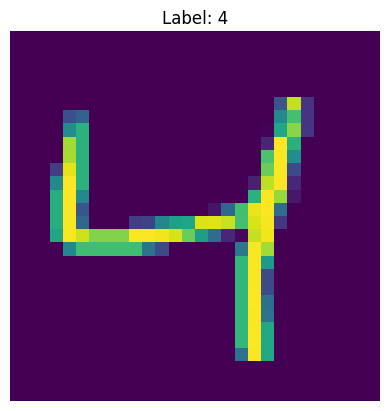

In [3]:
# 데이터셋 중 하나의 이미지를 시각화해보기
import matplotlib.pyplot as plt
import numpy as np

# 데이터셋에서 하나의 샘플 가져오기
image, label = train_subset[1]

# 텐서를 NumPy 배열로 변환
image = image.numpy().squeeze()

# 이미지 출력
plt.imshow(image)  # 이미지 표시
plt.title(f"Label: {label}")  # 레이블 표시
plt.axis("off")  # 축 없애기
plt.show()

<a id="1"></a> <br>
## **1. ANN**

**인공 신경망 (ANN)**

>  로지스틱 회귀는 분류 문제에서 성능이 좋지만, 데이터의 비선형성이 증가하면 모델의 정확도가 감소합니다.

>  따라서, hidden lyaer 에 더 많은 비선형 함수를 추가시켜 모델의 복잡도를 증가시켜 봅시다. 😀

↪ **3개의 hidden layer를 쌓고 다양한 활성화 함수 ReLU, Tanh, ELU 사용해봅시다**


In [4]:
# 필요한 라이브러리 임포트
import torch
import torch.nn as nn

#### **ANN 모델 생성**

In [5]:
# ANN Model
class ANNModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()

        # Linear function 1: input_dim --> hidden_dim  (입력 차원에서 숨겨진 계층으로)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Non-linearity 1 (ReLU 활성화 함수)
        self.relu1 = nn.ReLU()

        # Linear function 2: hidden_dim --> hidden_dim  (숨겨진 계층을 한 번 더 통과)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 2 (Tanh 활성화 함수 사용)
        self.tanh2 = nn.Tanh()

        # Linear function 3: hidden_dim --> hidden_dim  (추가 숨겨진 계층)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 3 (ELU 활성화 함수)
        self.elu3 = nn.ELU()

        # Linear function 4: hidden_dim --> output_dim  (마지막 출력층)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)

        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.tanh2(out)

        # Linear function 3
        out = self.fc3(out)
        # Non-linearity 3
        out = self.elu3(out)

        # Linear function 4
        out = self.fc4(out)  # 마지막 출력층
        return out

In [6]:
# ANN 객체 생성
input_dim = 28 * 28  # 이미지 크기 (28x28)
hidden_dim = 150  # 하이퍼파라미터 (150으로 설정)
output_dim = 5  # 출력 클래스 개수 (0~4)


model = ANNModel(input_dim,hidden_dim,output_dim)
# 손실 함수 설정
loss_ftn = nn.CrossEntropyLoss() # 다중분류에 적합한 손실함수를 선택해주세요

# SGD Optimizer 사용 - 다른 옵티마이저를 사용해보셔도 됩니다 :)
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#### **ANN 모델 학습**

In [7]:
# ANN 모델 학습

# 학습을 모니터링하기 위한 변수들
count = 0  # 반복 횟수
loss_list = []  # Loss 저장 리스트
iteration_list = []  # Iteration 저장 리스트
accuracy_list = []  # 정확도 저장 리스트

# 전체 학습
for epoch in range(10):

    # 배치 단위 학습
    for i, (images, labels) in enumerate(train_loader):

        # 데이터를 모델 입력 형태로 변환 (2D 텐서로 펼치기)
        train = images.view(-1, 784)  # 28x28 이미지를 펼쳐서 1D 벡터로 변환
        labels = labels  # 텐서 형태 유지

        # 옵티마이저의 기울기 초기화
        optimizer.zero_grad()

        # Forward
        # 모델을 이용해 예측값(outputs) 계산
        outputs = model(train)

        # 손실 계산
        # cross entropy loss를 사용해 예측값과 실제값 비교
        loss = loss_ftn(outputs, labels)

        # Backward propagation - 손실에 대한 기울기 계산
        loss.backward()

        # 가중치 업데이트
        optimizer.step()

        count += 1  # 반복 횟수 증가

        if count % 50 == 0:
            # 정확도 계산을 위한 변수 초기화
            correct = 0
            total = 0


            # 모델이 테스트 데이터셋에서 얼마나 잘 예측하는지 확인
            for images, labels in test_loader:

                test = images.view(-1, 784)  # 28x28 이미지를 펼쳐서 1D 벡터로 변환
                # Forward
                # 예측값 계산
                outputs = model(test)

                # 예측값 중 가장 높은 값을 선택
                predicted = torch.max(outputs.data, 1)[1]

                # 총 샘플 개수
                total += len(labels)

                # 올바르게 예측한 개수
                correct += (predicted == labels).sum()

            # 정확도 계산
            accuracy = 100 * correct / float(total)

            # 손실 및 정확도 저장
            loss_list.append(loss.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if count % 500 == 0:
            # 손실 및 정확도 출력
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))


Iteration: 500  Loss: 0.14249905943870544  Accuracy: 95.95252227783203 %
Iteration: 1000  Loss: 0.060348670929670334  Accuracy: 97.23681640625 %
Iteration: 1500  Loss: 0.11039315164089203  Accuracy: 97.45086669921875 %
Iteration: 2000  Loss: 0.0969020426273346  Accuracy: 97.64545440673828 %
Iteration: 2500  Loss: 0.15290498733520508  Accuracy: 97.87896728515625 %
Iteration: 3000  Loss: 0.20010323822498322  Accuracy: 98.07355499267578 %
Iteration: 3500  Loss: 0.08366566896438599  Accuracy: 98.1513900756836 %
Iteration: 4000  Loss: 0.01241294015198946  Accuracy: 98.32652282714844 %
Iteration: 4500  Loss: 0.016845514997839928  Accuracy: 98.42382049560547 %


#### **ANN 학습 결과**

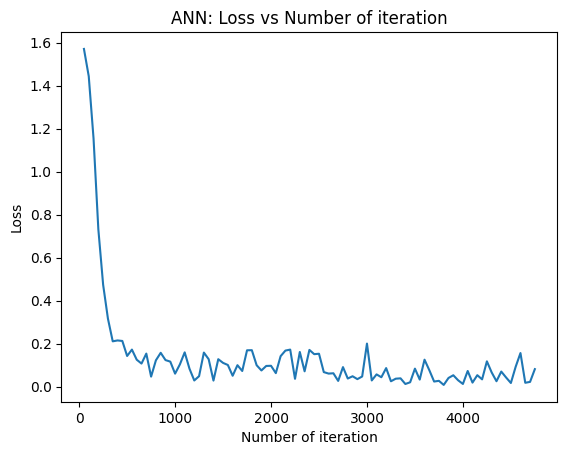

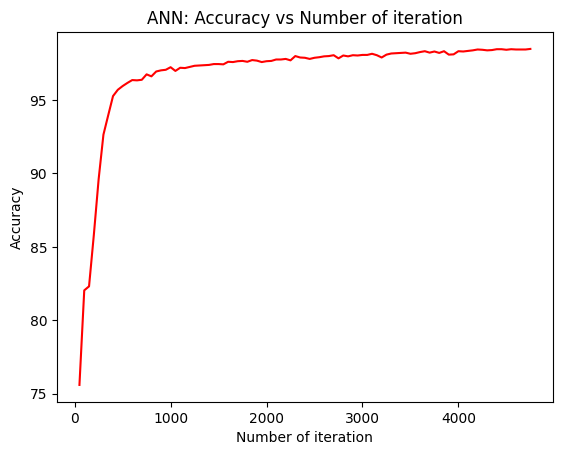

In [8]:
# loss 시각화
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()

# accuracy 시각화
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()

**해당 셀의 마크 다운을 풀고 시각화된 모델의 학습 결과를 해석해주세요.** 🤗



---
**[해석]**

Loss
- 초기 급감 구간: 이터레이션 0 부분에서 손실이 약 1.5->0.2까지 빠르게 하강함. (현재 설정이 초기 방향을 잘 잡고 있다는 것을 시사함)
- 완만한 수렴 구간: 손실이 약 0.05로 안정화 (모델이 결정 경계를 다듬는 단계로 진입함)
- 소규모 요동: 이터레이션 3천쯤에 작은 스파크 (정상 범위의 변동)

Accuracy
- 초기 가파른 상승 구간: 정확도가 약 75%->92%로 급상승 (기본적인 숫자 구분 규칙을 빠르게 학습함)
- 완만한 상승 후 고원: 이후 점차 상승하고 평탄화 (미세 조정 단계에 진입했음을 보임. 과적합은 보이지 않음)

시사점
- ReLU - Tanh - ELU 조합에서도 학습은 안정적
- 옵티마이저: 순수 SGD에 학습률 0.02로 빠르게 수렴함



#### **ANN 최적의 하이퍼파라미터 찾기**

1️⃣ **실험 1: Hidden Dimension 최적값 찾기**
- hidden_dim 값을 50-200 사이 값들로 설정하고 모델을 학습
- 각 hidden_dim 값에 대해 학습을 수행하면서 loss과 accuracy를 저장
- 모든 결과를 한 그래프에 표시하여 비교




2️⃣ **실험 2: Learning Rate 최적값 찾기**

- learning_rate 값을 0.1-0.005 사이 값들로 설정하고 모델을 학습
- 각 learning_rate 값에 대해 학습을 수행하면서 loss과 accuracy를 저장
- 모든 결과를 한 그래프에 표시하여 비교



**⚠ 이때 epoch 값은 자유롭게 해주셔도 됩니다! **

In [9]:
# 실험 1 hidden_dims=[50-200 사이 값들] 로 학습
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict

# 실험 설정
hidden_dims = [50, 100, 150, 200]
num_epochs = 5
learning_rate = 0.02
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 정의
class ANNModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super().__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(hidden_dim, hidden_dim)
    self.tanh2 = nn.Tanh()
    self.fc3 = nn.Linear(hidden_dim, hidden_dim)
    self.elu3 = nn.ELU()
    self.fc4 = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    # x (B, 1, 28, 28) -> (B, 784)
    x = x.view(x.size(0), -1)
    out = self.fc1(x); out = self.relu1(out)
    out = self.fc2(out); out = self.tanh2(out)
    out = self.fc3(out); out = self.elu3(out)
    out = self.fc4(out)
    return out

# 학습 유틸 함수
def train_once(hidden_dim):
  model = ANNModel(28*28, hidden_dim, 5).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learning_rate)
  history = defaultdict(list)
  global_step = 0
  for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      global_step +=1

      if global_step % 50 == 0:
        history["iter"].append(global_step)
        history["loss"].append(loss.item())
    # epoch 마지막에 테스트 정확도 측정
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        preds = logits.argmax(dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
    acc = 100.0 * correct / total
    history["epoch"].append(epoch + 1)
    history["acc"].append(acc)

  return history

# 모든 hidden_dim
all_hist = {}
for h in hidden_dims:
  print(f"[Run] hidden_dim={h}")
  all_hist[h] = train_once(h)

[Run] hidden_dim=50
[Run] hidden_dim=100
[Run] hidden_dim=150
[Run] hidden_dim=200


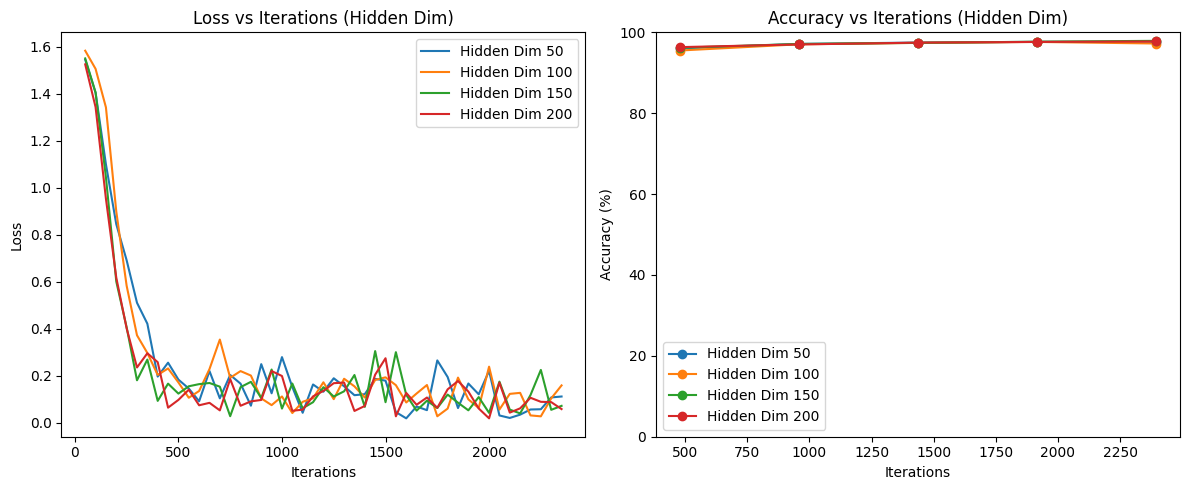

In [11]:
# 실험 1 모델 학습 결과 시각화
import matplotlib.pyplot as plt

# 한 에포크에 발생하는 이터레이션 수
# train_loader 길이와 일치
iters_per_epoch = len(train_loader)

# 그림 크기 설정
plt.figure(figsize=(12, 5))

# Loss vs Iterations
ax1 = plt.subplot(1, 2, 1)
for h, hist in all_hist.items():
    iters = hist["iter"]
    losses = hist["loss"]
    ax1.plot(iters, losses, label=f"Hidden Dim {h}")
ax1.set_title("Loss vs Iterations (Hidden Dim)")
ax1.set_xlabel("Iterations") # 이터레이션 번호
ax1.set_ylabel("Loss") # 배치 손실
ax1.legend()

# Accuracy vs Iterations
# 정확도는 에포크 종료 시점마다 한 번 측정
# x축을 해당 에포크의 누적 이터레이션 번호로 매핑하여 라인 그래프로 표시
ax2 = plt.subplot(1, 2, 2)
for h, hist in all_hist.items():
    epochs = hist["epoch"]
    accs = hist["acc"] # 각 에포크 종료 시점 정확도
    # 각 에포크 종료 시점의 누적 이터레이션 = 에포크 번호 × 이터레이션당 배치 수
    acc_x = [e * iters_per_epoch for e in epochs]
    ax2.plot(acc_x, accs, marker="o", label=f"Hidden Dim {h}")
ax2.set_title("Accuracy vs Iterations (Hidden Dim)")
ax2.set_xlabel("Iterations") # 누적 이터레이션 번호로 변환
ax2.set_ylabel("Accuracy (%)")
ax2.set_ylim(0, 100) # 정확도 범위 고정
ax2.legend()

plt.tight_layout()
plt.show()



**해당 셀의 마크 다운을 풀고 hidden dimension 값이 모델의 학습에 주는 영향을 설명해주세요.** 🤗



---
**[답변]**
- 수렴 속도: h=50은 같은 이터레이션에서 다른 값들보다 손실이 더 높고 정확도 상승도 약간 느리다
- 최종 정확도 상한: h=150, h=200 > h=100 > h=50
- 손실 곡선: 큰 차원일 수록 미니 배치 잡음에 반응하는 폭이 약간 커진다
- 계산 비용: 은닉 차원 수가 커질수록 연산량과 메모리 사용량이 선형에 가깝게 증가한다

In [12]:
# 실험 2 learning_rates=[0.1-0.005 사이 값들] 로 학습
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict

# 실험 설정
learning_rates = [0.1, 0.05, 0.02, 0.005]
num_epochs_lr = 7
log_every = 50 # 손실 로깅 간격
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_with_lr(lr):
    # 주어진 학습률로 학습하고 손실/정확도 기록 반환
    model = ANNModel(28*28, 150, 5).to(device) # hidden_dim은 고정
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    hist = defaultdict(list)
    global_step = 0

    for epoch in range(num_epochs_lr):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            # forward -> loss -> backward -> step
            logits = model(images)
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            global_step += 1
            if global_step % log_every == 0:
                hist["iter"].append(global_step)
                hist["loss"].append(loss.item())

        # 에포크 마지막에 테스트 정확도 측정
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                logits = model(images)
                preds = logits.argmax(dim=1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()
        acc = 100.0 * correct / total
        hist["epoch"].append(epoch + 1)
        hist["acc"].append(acc)
        model.train()

    return hist

# 모든 학습률에 대해 실행
all_hist_lr = {}
for lr in learning_rates:
    print(f"[Run] lr={lr}")
    all_hist_lr[lr] = train_with_lr(lr)


[Run] lr=0.1
[Run] lr=0.05
[Run] lr=0.02
[Run] lr=0.005


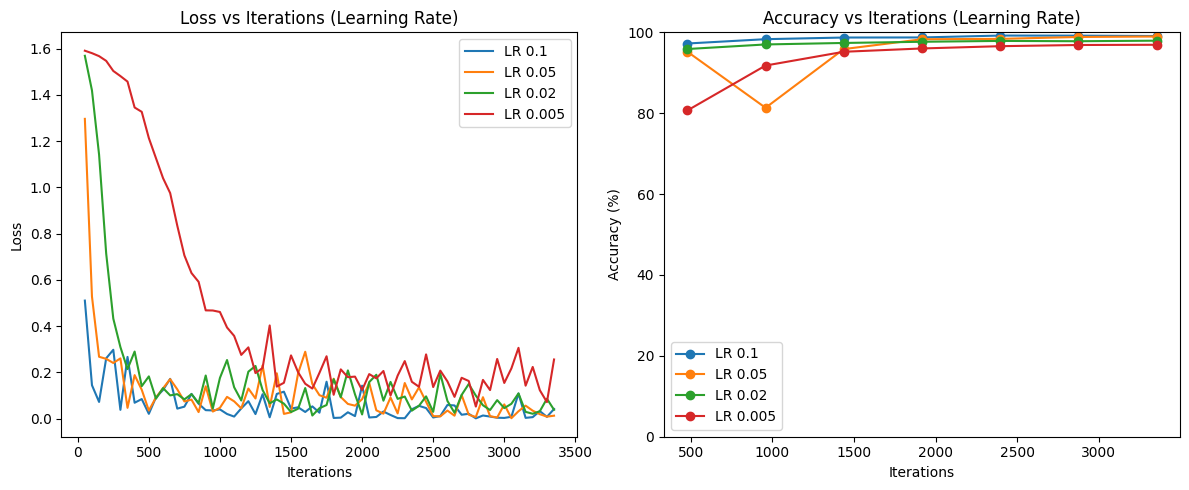

In [13]:
# 실험 2 모델 학습 결과 시각화
import matplotlib.pyplot as plt

iters_per_epoch = len(train_loader) # epoch당 이터레이션 수
plt.figure(figsize=(12, 5))

# Loss vs Iterations
ax1 = plt.subplot(1, 2, 1)
for lr, hist in all_hist_lr.items():
    ax1.plot(hist["iter"], hist["loss"], label=f"LR {lr}")
ax1.set_title("Loss vs Iterations (Learning Rate)")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")
ax1.legend()

# Accuracy vs Iterations
ax2 = plt.subplot(1, 2, 2)
for lr, hist in all_hist_lr.items():
    acc_x = [e * iters_per_epoch for e in hist["epoch"]]
    ax2.plot(acc_x, hist["acc"], marker="o", label=f"LR {lr}")
ax2.set_title("Accuracy vs Iterations (Learning Rate)")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Accuracy (%)")
ax2.set_ylim(0, 100)
ax2.legend()

plt.tight_layout()
plt.show()


**해당 셀의 마크 다운을 풀고 learning rate 값이 모델의 학습에 주는 영향을 설명해주세요.** 🤗



---
**[답변]**
1. 수렴 속도
- LR이 클수록 같은 시간 대비 학습이 빨라진다
2. 안정성 (발산 위험)
- LR이 너무 크면 손실이 왔다갔다하거나 발산할 수 있다
- 너무 큰 LR은 위험하고 너무 작은 LR은 느리다 (트레이드오프)
3. 최종 정확도 상한
- 최종 도달점은 비슷하지만 도달하는 시간 차이가 크다


<a id="1"></a> <br>
## **2. CNN**
> CNN은 이미지 분류에 적합한 모델로, kernel을 이용해 feature map을 생성합니다

**↪ 2개의 합성곱 계층을 쌓고, 활성화 함수로 ReLU를 사용하며,Max Pooling layer를 적용해봅시다.**

#### **CNN 모델 생성**

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

# CNN Model 정의
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # 합성곱 계층 1 (Conv Layer 1)
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU() # 활성화 함수 (ReLU)

        # Max Pooling 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)  # kernel size를 2로 설정

        # 합성곱 계층 2 (Conv Layer 2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()  # 활성화 함수 (ReLU)

        # Max Pooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) # kernel size를 2로 설정

        # Fully Connected Layer
        self.fc1 = nn.Linear(32 * 4 * 4, 5)  # 입력 차원 및 출력 차원 지정

    def forward(self, x):
        # 합성곱 계층 1 + 활성화 함수
        out = self.cnn1(x)
        out = self.relu1(out)

        # Max Pooling 1
        out = self.maxpool1(out)

        # 합성곱 계층 2 + 활성화 함수
        out = self.cnn2(out)
        out = self.relu2(out)

        # Max Pooling 2
        out = self.maxpool2(out)

        # feature map을 flatten하게
        out = out.view(out.size(0), -1)

        # 완전 연결 계층
        out = self.fc1(out)

        return out


In [16]:
# CNN 객체 생성
model = CNNModel()
# 손실 함수 설정
loss_ftn = nn.CrossEntropyLoss()  # 다중분류에 적합한 손실함수를 선택해주세요

# SGD Optimizer 사용 - 다른 옵티마이저를 사용해보셔도 됩니다 :)
optimizer = optim.SGD(model.parameters(), lr=0.02)  # 학습률을 자유롭게 설정해주세요

#### **CNN 모델 학습**

In [17]:
# CNN 모델 학습

# 학습을 모니터링하기 위한 변수들
count = 0  # 반복 횟수
loss_list = []  # Loss 저장 리스트
iteration_list = []  # Iteration 저장 리스트
accuracy_list = []  # 정확도 저장 리스트
num_epochs = 20  # 학습할 에포크 수 설정 -> 자유롭게 설정해주셔도 됩니다

for epoch in range(num_epochs):
    running_loss = 0.0  # 에포크별 손실 초기화

    for images, labels in train_loader:
        # 옵티마이저의 기울기 초기화
        optimizer.zero_grad()

        # Forward
        outputs = model(images)

        # 손실 계산
        loss = loss_ftn(outputs, labels)

        # Backward
        loss.backward()

        # 가중치 업데이트
        optimizer.step()

        # 손실 누적
        running_loss += loss.item()
        count += 1  # 반복 횟수 증가

        if count % 50 == 0:
            correct = 0
            total = 0

            with torch.no_grad():  # 평가
                for images, labels in test_loader:
                    # 모델 예측 수행
                    outputs = model(images)

                    # 가장 확률이 높은 클래스 선택
                    predicted = torch.max(outputs.data, 1)[1]

                    # 총 샘플 수 및 올바른 예측 개수 누적
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            # 정확도 계산
            accuracy = 100 * correct / float(total)

            # 손실 및 정확도 저장
            loss_list.append(loss.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)

    # 매 에포크마다 평균 손실 출력
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

Epoch 1, Loss: 0.34552033360666423
Epoch 2, Loss: 0.09138440868247588
Epoch 3, Loss: 0.0687394541875889
Epoch 4, Loss: 0.05629799432667567
Epoch 5, Loss: 0.04791956986004141
Epoch 6, Loss: 0.04192022259605004
Epoch 7, Loss: 0.037820075164667656
Epoch 8, Loss: 0.03390003482970252
Epoch 9, Loss: 0.03132455817487923
Epoch 10, Loss: 0.02852776036685282
Epoch 11, Loss: 0.027042126432761146
Epoch 12, Loss: 0.025042329855323505
Epoch 13, Loss: 0.023127234608930437
Epoch 14, Loss: 0.022024496278379477
Epoch 15, Loss: 0.02128188978622537
Epoch 16, Loss: 0.02021403481179094
Epoch 17, Loss: 0.019118281120448014
Epoch 18, Loss: 0.01791072603996108
Epoch 19, Loss: 0.017246620661393392
Epoch 20, Loss: 0.016799057563903243


#### **CNN 학습 결과**

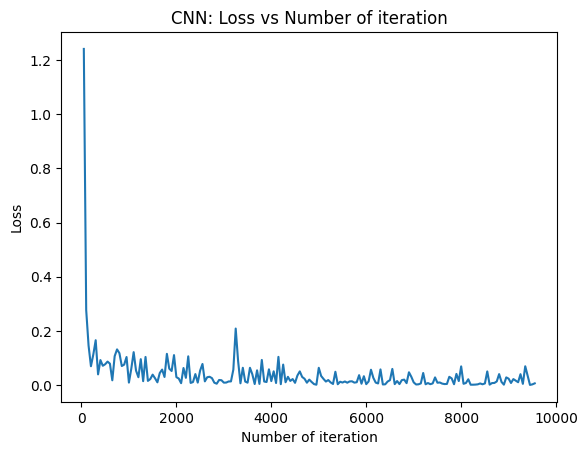

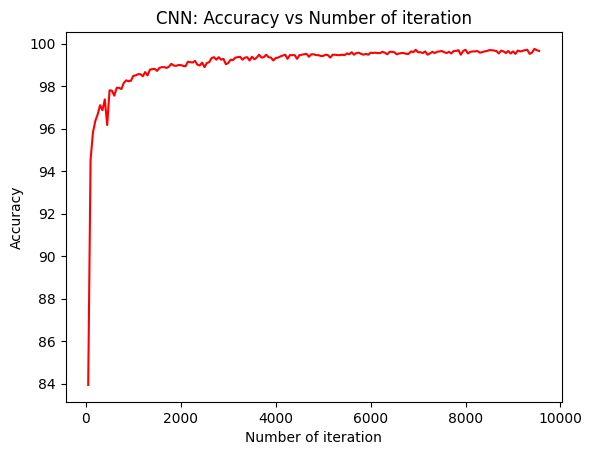

In [18]:
# loss 시각화
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# accuracy 시각화
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

**해당 셀의 마크 다운을 풀고 MNIST 데이터셋에서 ANN, CNN의 학습 결과 비교와 함께 두 모델에 대해 각각 짧게 소개해주세요.** 🤗



---
**ANN vs CNN**
1. 정확도
- CNN의 최종 상한이 ANN보다 약간 더 높게 형성됨
2. 손실 곡선
- ANN: 초반 급감 후 낮은 수준에서 움직임. 미니배치에 따른 변동
- CNN: 초반 급감 후 매우 낮은 손실로 수렴하며 요동 폭이 더 작음
3. 수렴 속도
- CNN이 ANN보다 더 빠른 상승으로 고정밀 구간에 빨리 진입하는 경향. 같은 이터레이션 대비 정확도 상승폭이 크게 보임


**ANN (Artificial Neural Network)**
1. 구조: 입력 -> 여러 개의 Linear 은닉층 -> 출력
- 활성화 함수로 ReLU, Tanh 등 사용
2. 입력 방식: MNIST 이미지를 (28x28)에서 1차원 벡터로 펼쳐서 입력
3. 장점: 구현이 간단함, 범용 작업에 적용
4. 단점: 공간적 인접성 정보를 명시적으로 활용하지 못함. 픽셀 위치 관계가 소실. 이미지 입력시 과적합 위험 증가

**CNN (Convolutional Neural Network)**
- 합성곱 커널로 지역 패턴 추출, 가중치 공유로 파라미터 절감, 평행 이동에 대한 강건성 확보
1. 구조: 28 → Conv5 → 24 → Pool2 → 12 → Conv5 → 8 → Pool2 → 4
2. 장점: 국소 패턴/계층적 특징 자동 학습, 적은 파라미터로 높은 성능
3. 단점: 구조 설계에 커널 크기, 스트라이드, 패딩 등 하이퍼파라미터 선택 필요
- 이미지 분류 등 공간 구조가 중요한 시각 데이터에 주로 활용

